In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
%matplotlib inline
import seaborn as sns
from networkx.algorithms import community
from networkx.algorithms import tree
import networkx as nx
import math
from itertools import chain, combinations
import matplotlib.pyplot as plt
from itertools import islice
from scipy.cluster.hierarchy import dendrogram
# from helper import community_layout

In [2]:
import networkx as nx
from itertools import chain, combinations
import matplotlib.pyplot as plt
from scipy.cluster.hierarchy import dendrogram


def community_layout(g, partition):
    """
    Compute the layout for a modular graph.


    Arguments:
    ----------
    g -- networkx.Graph or networkx.DiGraph instance
        graph to plot

    partition -- dict mapping int node -> int community
        graph partitions


    Returns:
    --------
    pos -- dict mapping int node -> (float x, float y)
        node positions

    """

    pos_communities = _position_communities(g, partition, scale=8.)

    pos_nodes = _position_nodes(g, partition, scale=2.2)

    # combine positions
    pos = dict()
    for node in g.nodes():
        pos[node] = pos_communities[node] + pos_nodes[node]

    return pos


def _position_communities(g, partition, **kwargs):

    # create a weighted graph, in which each node corresponds to a community,
    # and each edge weight to the number of edges between communities
    between_community_edges = _find_between_community_edges(g, partition)

    communities = set(partition.values())
    hypergraph = nx.DiGraph()
    hypergraph.add_nodes_from(communities)
    for (ci, cj), edges in between_community_edges.items():
        hypergraph.add_edge(ci, cj, weight=len(edges))

    # find layout for communities
    pos_communities = nx.spring_layout(hypergraph, **kwargs)

    # set node positions to position of community
    pos = dict()
    for node, community in partition.items():
        pos[node] = pos_communities[community]

    return pos


def _find_between_community_edges(g, partition):

    edges = dict()

    for (ni, nj) in g.edges():
        ci = partition[ni]
        cj = partition[nj]

        if ci != cj:
            try:
                edges[(ci, cj)] += [(ni, nj)]
            except KeyError:
                edges[(ci, cj)] = [(ni, nj)]

    return edges


def _position_nodes(g, partition, **kwargs):
    """
    Positions nodes within communities.
    """

    communities = dict()
    for node, community in partition.items():
        try:
            communities[community] += [node]
        except KeyError:
            communities[community] = [node]

    pos = dict()
    for ci, nodes in communities.items():
        subgraph = g.subgraph(nodes)
        pos_subgraph = nx.spring_layout(subgraph, **kwargs)
        pos.update(pos_subgraph)

    return pos


In [7]:
### Original 119 CCs from practicum
cc_list = ['bitcoin', 'peercoin', 'ripple', 'nxt', 'dogecoin', 'vertcoin', 'digibyte',
           'reddcoin', 'dash', 'counterparty', 'gulden', 'einsteinium', 'monacoin', 'maidsafecoin',
           'monero', 'nav-coin', 'bytecoin-bcn', 'digitalnote', 'bitcoindark', 'viacoin', 'bitshares',
           'stellar', 'syscoin', 'gamecredits', 'ubiq', 'supernet-unity', 'emercoin', 'verge', 'blocknet',
           'bitbay', 'nexus', 'tether', 'nem', 'ethereum', 'siacoin', 'factom', 'agoras-tokens', 'paccoin',
           'augur', 'decred', 'pivx', 'lisk', 'steem', 'digixdao', 'waves', 'ion', 'ethereum-classic',
           'stratis', 'neo', 'ardor', 'iconomi', 'singulardtv', 'zcoin', 'triggers', 'zcash', 'zclassic',
           'golem-network-tokens', 'experience-points', 'byteball', 'wings', 'komodo', 'melon', 'raiblocks',
           'ark', 'edgeless', 'asch', 'e-coin', 'skycoin', 'xtrabytes', 'rlc', 'bitcore', 'gnosis-gno', 'aragon',
           'qtum', 'zencash', 'basic-attention-token', 'aeternity', 'veritaseum', 'quantum-resistant-ledger',
           'mobilego', 'iota', 'sonm', 'bancor', 'gxshares', 'funfair', 'tenx', 'status', 'eos', 'adx-net',
           'storj', 'monaco', 'wagerr', 'gas', 'metal', 'populous', 'santiment', 'omisego', 'civic', 'ethos',
           'particl', 'smartcash', 'bitcoin-cash', 'pillar', 'binance-coin', 'coindash', 'bytom', 'dentacoin',
           'centra', 'dent', '0x', 'hshare', 'vechain', 'tierion', 'walton', 'loopring', 'poet', 'neblio', 'tron',
           'decentraland']

In [8]:
def preprocessing():
    """
    Import CC pairs data and select candidate pairs and create target dataframe 
    
    returns:
        - target_df: close_time, close_price, pair
    """
    
    all_pairs = pd.read_csv('./cryptowatch_all_assets_all_exchanges.csv')
    lookup_pairs = pd.read_csv('./cryptowatch_lookup_pairs.csv')

    all_pairs = all_pairs.merge(lookup_pairs, left_on=['pair'], right_on=['pair_symbol'])


    cols = ['base_name', 'quote_name']
    for i in range(len(cols)):
        all_pairs[cols[i]] = all_pairs[cols[i]].str.lower()

    usd_quote_pairs = all_pairs[all_pairs.quote_symbol == 'usd']
    pair_base_list = list(usd_quote_pairs.base_name.str.lower().unique())
    # pair_base_list = list(all_pairs[all_pairs.quote_symbol == 'usd'].base_name.str.lower().unique())

    new_cc_list = list(set(pair_base_list) & set(cc_list))

    target_pairs = usd_quote_pairs[usd_quote_pairs.base_name.isin(new_cc_list)]
    target_pairs = target_pairs[~target_pairs.pair.str.contains('futures')]

    candidate_pairs_list = target_pairs.groupby(['pair']).size().reset_index().sort_values(by=[0])
    candidate_pairs_list = candidate_pairs_list[candidate_pairs_list[0] > 400]
    candidate_pairs_list = list(candidate_pairs_list.pair)

    candidate_pairs = target_pairs[target_pairs.pair.isin(candidate_pairs_list)]

    min_max = candidate_pairs.groupby('pair').agg(['min', 'max'])['close_time'].sort_values(by=['min'])
    filtered_pair_list = list(min_max[pd.to_datetime(min_max['min']) < '2019-03-01'].index)

    candidate = target_pairs[target_pairs.pair.isin(filtered_pair_list)]
    candidate['close_time'] = pd.to_datetime(candidate.close_time)

    target_df = candidate[['close_time', 'close_price', 'pair']]
    target_df.reset_index(inplace=True, drop=True)
    
    return target_df

In [9]:
all_pairs = pd.read_csv('./cryptowatch_all_assets_all_exchanges.csv')
lookup_pairs = pd.read_csv('./cryptowatch_lookup_pairs.csv')

all_pairs = all_pairs.merge(lookup_pairs, left_on=['pair'], right_on=['pair_symbol'])


cols = ['base_name', 'quote_name']
for i in range(len(cols)):
    all_pairs[cols[i]] = all_pairs[cols[i]].str.lower()

usd_quote_pairs = all_pairs[all_pairs.quote_symbol == 'usd']
pair_base_list = list(usd_quote_pairs.base_name.str.lower().unique())
# pair_base_list = list(all_pairs[all_pairs.quote_symbol == 'usd'].base_name.str.lower().unique())

In [10]:
target_pairs = usd_quote_pairs[~usd_quote_pairs.pair.str.contains('futures')]
candidate_pairs_list = target_pairs.groupby(['pair']).size().reset_index().sort_values(by=[0])


In [11]:
candidate_pairs_list = candidate_pairs_list[candidate_pairs_list[0] > 400]
candidate_pairs_list = list(candidate_pairs_list.pair)

candidate_pairs = target_pairs[target_pairs.pair.isin(candidate_pairs_list)]

min_max = candidate_pairs.groupby('pair').agg(['min', 'max'])['close_time'].sort_values(by=['min'])

In [12]:
min_max = min_max[:80]

In [13]:
filtered_pair_list = list(min_max[pd.to_datetime(min_max['min']) < '2019-03-01'].index)

candidate = target_pairs[target_pairs.pair.isin(filtered_pair_list)]
candidate['close_time'] = pd.to_datetime(candidate.close_time)

target_df = candidate[['close_time', 'close_price', 'pair']]
target_df.reset_index(inplace=True, drop=True)

# return target_df

<ipython-input-13-c60fa4daab27>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate['close_time'] = pd.to_datetime(candidate.close_time)


In [14]:
target_df

,close_time,close_price,pair
0,2015-01-27,274.480011,btcusd
1,2015-01-28,263.649994,btcusd
2,2015-01-29,236.089996,btcusd
3,2015-01-30,235.029999,btcusd
4,2015-01-31,229.070007,btcusd
...,...,...,...
139376,2020-05-15,0.006000,yoyowusd
139377,2020-05-16,0.005969,yoyowusd
139378,2020-05-17,0.005761,yoyowusd
139379,2020-05-18,0.005997,yoyowusd


In [15]:
target_df['pair'] = target_df['pair'].map(usd_quote_pairs[['pair_symbol', 'base_name']].drop_duplicates().set_index('pair_symbol')['base_name'])

<ipython-input-15-2b6e26309b8d>:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  target_df['pair'] = target_df['pair'].map(usd_quote_pairs[['pair_symbol', 'base_name']].drop_duplicates().set_index('pair_symbol')['base_name'])


In [16]:
def create_ts_matrix():
    """
    Create A Matrix with index as dates and each column as a CC pair
    """    
    
    grouped = target_df.groupby('pair')
    dates = grouped.apply(lambda x: [x.close_time, x.close_price])
    # target_df.set_index(['close_time'])

    grouper = target_df.set_index('close_time').groupby([pd.Grouper(freq='D'), 'pair'])
    result = grouper['close_price'].mean().unstack('pair').fillna(0)
    # result = grouper['close_price'].mean().fillna(0)
    
    return result

In [17]:
def apply_log_returns(df):
    cols = list(df.columns)
    for i in range(len(cols)):
        df[cols[i]] = np.log(df[cols[i]]/df[cols[i]].shift(1)).dropna()
#         df[cols[i]] = np.log(df[cols[i]]).diff()
    return df

In [18]:
def compute_distance_matrix():
    """
    Computes Correlation Matrix from the CC matrix, 
    and computes distance matrix from correlation matrix
    
    returns:
        - Distance matrix dataframe
    """
    
    corr_result = result_filtered.corr().values
    
    ## Distance formula d(i,j) = 1-p(i,j)^2
    dist_mat = corr_result
    for i in range(len(corr_result)):
        for j in range(len(corr_result)):
            dist_mat[i][j] = 1 - (corr_result[i][j]**2)
    
    ## CC names
    cols =list(result_filtered.columns)
    
    df_dist_mat = pd.DataFrame(dist_mat, columns=cols, index=cols)
    
    return df_dist_mat
  
    
def compute_adjacency_matrix():
    """
    Computes Correlation Matrix from the CC matrix, 
    and computes weighted adjacency matrix from correlation matrix
    
    returns:
        - Weighted matrix dataframe
    """
    
    corr_result = result_filtered.corr().values
    
    ## adjacency matrix is abs of correlation matrix
    corr_result = abs(corr_result)
    
    ## CC names
    cols =list(result_filtered.columns)
    
    df_adj_mat = pd.DataFrame(corr_result, columns=cols, index=cols)
    
    return df_adj_mat


In [19]:
def create_mst():
    G = nx.from_pandas_adjacency(df_dist_mat)
    mst = tree.minimum_spanning_tree(G, algorithm='kruskal')
    return mst

In [20]:
def plot_mst():
    plt.figure(figsize=(10, 10))
    plt.tight_layout()
    # nx.draw_networkx_labels(mst,pos=nx.spring_layout(mst))
    nx.draw(mst,pos=nx.spring_layout(mst, k=None), with_labels=True)

In [21]:
def girvan_newman_dendogram():
    """
    Computes Girvan Newman Communities and plots dendogram
    """
    
    # G = nx.from_pandas_adjacency(df_dist_mat)
    G = mst
    communities = list(community.girvan_newman(G))
    # communities = list(next(communities))
    # building initial dict of node_id to each possible subset:
    node_id = 0
    init_node2community_dict = {node_id: communities[0][0].union(communities[0][1])}
    for comm in communities:
        for subset in list(comm):
            if subset not in init_node2community_dict.values():
                node_id += 1
                init_node2community_dict[node_id] = subset

    # turning this dictionary to the desired format in @mdml's answer
    node_id_to_children = {e: [] for e in init_node2community_dict.keys()}
    for node_id1, node_id2 in combinations(init_node2community_dict.keys(), 2):
        for node_id_parent, group in init_node2community_dict.items():
            if len(init_node2community_dict[node_id1].intersection(init_node2community_dict[node_id2])) == 0 and group == init_node2community_dict[node_id1].union(init_node2community_dict[node_id2]):
                node_id_to_children[node_id_parent].append(node_id1)
                node_id_to_children[node_id_parent].append(node_id2)

    # also recording node_labels dict for the correct label for dendrogram leaves
    node_labels = dict()
    for node_id, group in init_node2community_dict.items():
        if len(group) == 1:
            node_labels[node_id] = list(group)[0]
        else:
            node_labels[node_id] = ''

    # also needing a subset to rank dict to later know within all k-length merges which came first
    subset_rank_dict = dict()
    rank = 0
    for e in communities[::-1]:
        for p in list(e):
            if tuple(p) not in subset_rank_dict:
                subset_rank_dict[tuple(sorted(p))] = rank
                rank += 1
    subset_rank_dict[tuple(sorted(chain.from_iterable(communities[-1])))] = rank

    # my function to get a merge height so that it is unique (probably not that efficient)
    def get_merge_height(sub):
        sub_tuple = tuple(sorted([node_labels[i] for i in sub]))
        n = len(sub_tuple)
        other_same_len_merges = {k: v for k, v in subset_rank_dict.items() if len(k) == n}
        min_rank, max_rank = min(other_same_len_merges.values()), max(other_same_len_merges.values())
        range = (max_rank-min_rank) if max_rank > min_rank else 1
        return float(len(sub)) + 0.8 * (subset_rank_dict[sub_tuple] - min_rank) / range

    # finally using @mdml's magic, slightly modified:
    G           = nx.DiGraph(node_id_to_children)
    nodes       = G.nodes()
    leaves      = set( n for n in nodes if G.out_degree(n) == 0 )
    inner_nodes = [ n for n in nodes if G.out_degree(n) > 0 ]

    # Compute the size of each subtree
    subtree = dict( (n, [n]) for n in leaves )
    for u in inner_nodes:
        children = set()
        node_list = list(node_id_to_children[u])
        while len(node_list) > 0:
            v = node_list.pop(0)
            children.add( v )
            node_list += node_id_to_children[v]
        subtree[u] = sorted(children & leaves)

    inner_nodes.sort(key=lambda n: len(subtree[n])) # <-- order inner nodes ascending by subtree size, root is last

    # Construct the linkage matrix
    leaves = sorted(leaves)
    index  = dict( (tuple([n]), i) for i, n in enumerate(leaves) )
    Z = []
    k = len(leaves)
    for i, n in enumerate(inner_nodes):
        children = node_id_to_children[n]
        x = children[0]
        for y in children[1:]:
            z = tuple(sorted(subtree[x] + subtree[y]))
            i, j = index[tuple(sorted(subtree[x]))], index[tuple(sorted(subtree[y]))]
            Z.append([i, j, get_merge_height(subtree[n]), len(z)]) # <-- float is required by the dendrogram function
            index[z] = k
            subtree[z] = list(z)
            x = z
            k += 1

    # dendrogram
    plt.figure(figsize=(10,10))
    dendrogram(Z, labels=[node_labels[node_id] for node_id in leaves])
    plt.show()

In [22]:
def girvan_newman_graph(mst):
    """
    Create Girvan Newman Communities and Plots communitiy graph
    """
    
    gn_generator = community.girvan_newman(mst)

    gn_communities = next(islice(gn_generator, 3, None)) # Do 3 iterations only

    gn_dict_communities = {}

    for i, c in enumerate(gn_communities):
        print ("Community {}".format(i))
        for node in c:
            gn_dict_communities[node] = i + 1

    for node in mst:
        if node not in gn_dict_communities.keys():
            gn_dict_communities[node] = -1

    gn_pos = community_layout(mst, gn_dict_communities)
    from matplotlib import cm
    gn_colors = []
    for node in mst.nodes:
        gn_colors.append(cm.Set1(gn_dict_communities[node]))
    plt.figure(figsize=(30,30))
    nx.draw_networkx(mst, gn_pos, node_color=gn_colors, node_size=200, with_labels=True, font_size=12, label_pos=0.1)
    # nx.draw_networkx_edges(mst, gn_pos, alpha=0.05)
    plt.show()

## Call Functions

In [23]:
target_df = preprocessing()

<ipython-input-8-bd9edb2d3453>:38: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  candidate['close_time'] = pd.to_datetime(candidate.close_time)


In [24]:
result = create_ts_matrix()

In [25]:
len(list(result.columns))

29

## Filter the Time series based on date, or create windows

In [26]:
# base_names_list = pd.Series(result.columns).map(usd_quote_pairs[['pair_symbol', 'base_name']].drop_duplicates().set_index('pair_symbol')['base_name'])
# result.columns = list(base_names_list)

In [27]:
result

pair,antusd,btcusd,dashusd,dgbusd,eosusd,ethusd,funusd,iotausd,kmdusd,lrcusd,...,sntusd,trxusd,usdtusd,vetusd,xlmusd,xmrusd,xvgusd,zecusd,zenusd,zrxusd
close_time,,,,,,,,,,,,,,,,,,,,,
2013-10-08,0.0000,123.610000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
2013-10-09,0.0000,124.180000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
2013-10-10,0.0000,123.840000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
2013-10-11,0.0000,125.860000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
2013-10-13,0.0000,127.000000,0.000000,0.000000,0.000000,0.000000,0.00000,0.000000,0.00000,0.0,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.0000,0.000000,0.000000,0.00000,0.000000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-15,1.2673,10597.141611,3182.054857,0.021929,2.625476,3529.707923,0.00270,0.208755,0.54200,0.0,...,0.029509,0.015253,1.000462,0.004438,0.069478,65.3380,0.003418,43.429800,5.39833,0.343523
2020-05-16,1.0600,10149.649353,3041.254572,0.021446,2.581095,3373.208000,0.00259,0.196245,0.52642,0.0,...,0.028222,0.014932,0.999368,0.004483,0.066008,62.5985,0.003634,42.052600,5.33447,0.381873
2020-05-17,1.1093,10223.949239,3129.406366,0.020741,2.634800,3471.693538,0.00263,0.197225,0.54599,0.0,...,0.027379,0.015023,0.999712,0.004570,0.068145,65.2890,0.003229,42.651600,5.28010,0.385132


In [24]:
result.to_csv('/home/harshal/Works/practicum_github_repo/Crypto-Data/matrix_shaped_data.csv')

In [23]:
# window_start_dates = ['2019-03-01', '2019-06-01', '2019-09-01', '2019-12-01', '2020-03-01']
# window_end_dates = ['2019-06-01', '2019-09-01', '2019-12-01', '2020-03-01', '2020-05-10']

# window_start_dates = ['2019-03-01', '2019-09-01', '2020-03-01']
# window_end_dates = ['2019-09-01', '2020-03-01', '2020-05-10']

window_start_dates = ['2019-01-01', '2019-06-01', '2019-12-01']
window_end_dates = ['2019-06-01', '2019-12-01', '2020-05-10']


# window_start_dates = ['2019-01-01', '2019-03-01', '2019-06-01', '2019-09-01', '2019-12-01', '2020-03-01']
# window_end_dates = ['2019-03-01', '2019-06-01', '2019-09-01', '2019-12-01', '2020-03-01', '2020-05-10']


mst_list = []

# result_filtered = result[(result.index <= window_end_dates[2]) & (result.index >= window_start_dates[2])]
# result_filtered = apply_log_returns(result_filtered.copy())
# df_dist_mat = compute_distance_matrix()

dist_mat_list = []
adj_mat_list = []
for i in range(len(window_end_dates)):
    result_filtered = result[(result.index <= window_end_dates[i]) & (result.index >= window_start_dates[i])]
#     result_filtered = apply_log_returns(result_filtered.copy())
    df_dist_mat = compute_distance_matrix()
    df_dist_mat = df_dist_mat.dropna(how='all')
    dist_mat_list.append(df_dist_mat)
    
    df_adj_mat = compute_distance_matrix()
    df_adj_mat = df_adj_mat.dropna(how='all')
    adj_mat_list.append(df_adj_mat)
    
    
    mst = create_mst()
    mst_list.append(mst)
    print(i)
    


0
1
2


In [23]:
result_filtered

pair,antusd,btcusd,dashusd,dgbusd,eosusd,ethusd,funusd,iotausd,kmdusd,lrcusd,...,sntusd,trxusd,usdtusd,vetusd,xlmusd,xmrusd,xvgusd,zecusd,zenusd,zrxusd
close_time,,,,,,,,,,,,,,,,,,,,,
2019-12-01,0.00000,8163.600598,2819.685833,0.006745,2.758100,2899.887920,0.00296,0.210790,0.68000,0.000000,...,0.011228,0.015561,1.001692,0.006198,0.058061,54.9150,0.003851,29.0814,5.61700,0.257779
2019-12-02,0.00000,8025.042551,2800.916747,0.006670,2.791996,2881.902581,0.00289,0.206100,0.71898,0.000000,...,0.010972,0.016077,1.001934,0.007499,0.057633,53.6665,0.004000,27.9598,5.52900,0.258786
2019-12-03,0.00000,7945.891044,2752.970333,0.006500,2.689833,2833.554907,0.00286,0.209555,0.60603,0.000000,...,0.010954,0.015386,1.002058,0.007267,0.056739,54.2920,0.003800,27.8082,5.44100,0.248476
2019-12-04,0.55742,7874.906851,2330.658571,0.006600,2.702733,2792.938222,0.00287,0.204345,0.71499,0.000000,...,0.010705,0.015368,1.002220,0.007699,0.053419,49.0350,0.003800,26.9875,5.28412,0.244178
2019-12-05,0.55289,7778.301026,2679.462865,0.006545,2.631267,2758.294393,0.00323,0.198950,0.56022,0.000000,...,0.011105,0.014443,1.000840,0.007400,0.054988,52.9940,0.003701,26.7082,5.00000,0.228669
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-05-06,0.88739,9911.637400,3196.756898,0.023584,2.766180,3542.889231,0.00209,0.187850,0.52350,0.033283,...,0.023149,0.015891,1.000743,0.004513,0.073440,60.3505,0.003500,43.8932,5.52131,0.206033
2020-05-07,0.98276,9994.504533,3082.943286,0.022770,2.660027,3417.616846,0.00000,0.180620,0.51300,0.000000,...,0.025044,0.015645,1.000968,0.004300,0.069866,57.9015,0.003681,43.2400,5.48966,0.209807
2020-05-08,1.20000,10827.231667,2895.647125,0.024545,2.766372,3663.667308,0.00211,0.185225,0.54000,0.000000,...,0.028322,0.016123,1.001347,0.004570,0.071978,64.6805,0.004200,44.3748,5.64975,0.298159


In [33]:
adj_mat_list[0]

,antusd,btcusd,dashusd,dgbusd,eosusd,ethusd,funusd,iotausd,kmdusd,lrcusd,...,sntusd,trxusd,usdtusd,vetusd,xlmusd,xmrusd,xvgusd,zecusd,zenusd,zrxusd
antusd,0.000000,0.932598,0.977543,0.960702,0.912031,0.957452,0.875351,0.989976,0.948027,0.955794,...,0.947190,0.956533,0.992189,0.884314,0.950614,0.903643,0.918564,0.902844,0.939745,0.921849
btcusd,0.932598,0.000000,0.220347,0.688901,0.154862,0.050856,0.248396,0.461511,0.607698,0.999974,...,0.689685,0.698537,0.983549,0.288561,0.578080,0.047797,0.278983,0.266534,0.387348,0.688270
dashusd,0.977543,0.220347,0.000000,0.653576,0.296827,0.172940,0.390357,0.444582,0.625966,0.999790,...,0.742302,0.738961,0.997438,0.413636,0.550606,0.247464,0.337736,0.336556,0.567171,0.696565
dgbusd,0.960702,0.688901,0.653576,0.000000,0.503294,0.588167,0.602515,0.650291,0.430671,0.999937,...,0.694324,0.857128,0.992843,0.488372,0.473127,0.607585,0.511212,0.532437,0.776242,0.609304
eosusd,0.912031,0.154862,0.296827,0.503294,0.000000,0.158675,0.245978,0.567327,0.360095,0.997837,...,0.587810,0.697345,0.967480,0.118667,0.597608,0.085251,0.282866,0.193052,0.352625,0.626021
ethusd,0.957452,0.050856,0.172940,0.588167,0.158675,0.000000,0.273351,0.341845,0.593240,0.999932,...,0.668268,0.698406,0.997507,0.297217,0.469407,0.085661,0.213132,0.215885,0.467068,0.619994
funusd,0.875351,0.248396,0.390357,0.602515,0.245978,0.273351,0.000000,0.541106,0.597493,0.990158,...,0.581878,0.762310,0.999225,0.166155,0.412035,0.177352,0.188780,0.194104,0.572381,0.432597
iotausd,0.989976,0.461511,0.444582,0.650291,0.567327,0.341845,0.541106,0.000000,0.881169,0.999395,...,0.768113,0.770860,0.918762,0.674160,0.300504,0.491831,0.429650,0.375949,0.858084,0.528834
kmdusd,0.948027,0.607698,0.625966,0.430671,0.360095,0.593240,0.597493,0.881169,0.000000,0.993669,...,0.680831,0.934770,0.950205,0.348945,0.792509,0.525922,0.658189,0.623123,0.476178,0.819194
lrcusd,0.955794,0.999974,0.999790,0.999937,0.997837,0.999932,0.990158,0.999395,0.993669,0.000000,...,0.956435,0.996905,0.992982,0.987200,0.998415,0.999926,0.994894,0.998574,0.995835,0.995129


In [3]:
adj_mat_from_r = pd.read_csv('/home/harshal/Works/practicum_github_repo/Crypto-Data/adj_mat_from_R.csv')

In [4]:
### drop index column
adj_mat_from_r = adj_mat_from_r.set_index('Unnamed: 0')

In [5]:

import numpy as np
import matplotlib.pyplot as plt
import networkx as nx
import seaborn as sns

from kuramoto_model.kuramoto import Kuramoto

plt.style.use('seaborn')
sns.set_style("whitegrid")
sns.set_context("talk")


# Instantiate a random graph and transform into an adjacency matrix
# graph_nx = nx.erdos_renyi_graph(n=100, p=1) # p=1 -> all-to-all connectivity
# graph = nx.to_numpy_array(graph_nx)
# graph_nx = nx.from_pandas_adjacency(dist_mat_list[0])
graph_nx = nx.from_pandas_adjacency(adj_mat_from_r)
graph = nx.to_numpy_array(graph_nx)

In [58]:
np.random.normal(0,1,len(graph))

array([-1.85549438e+00,  1.64804662e+00, -2.68573291e-01, -1.21263338e+00,
        9.69181031e-01, -1.90074009e+00,  6.20756162e-01,  1.16148694e-01,
       -1.83730992e+00, -5.21641014e-01,  3.46060681e-01, -8.89040240e-01,
       -1.35617088e+00,  1.20232075e+00,  8.12270050e-01,  5.13050085e-01,
        5.96481451e-01, -1.91508630e-01, -1.24460847e+00,  9.42892665e-01,
        1.48630146e+00, -1.68943222e-01,  9.11353915e-01, -6.64078887e-01,
       -1.52753979e+00, -1.33305469e+00,  9.25856247e-01,  1.14696707e+00,
       -3.93984581e-01, -1.64288311e-01,  1.64245722e+00,  1.19125695e-01,
       -2.16199595e+00, -8.87903697e-01,  5.14030629e-01, -3.13178509e-01,
       -7.57882353e-01,  1.41910194e+00, -7.18950711e-01,  4.31642350e-01,
       -1.56950192e+00,  5.42256886e-01, -1.10077679e+00,  1.17979515e+00,
       -7.68554064e-01,  1.02302933e-01, -1.53970801e+00, -1.48001090e+00,
        6.46182474e-01, -5.75090932e-01, -1.79736216e+00, -1.07692843e-01,
       -3.54727144e-01,  

Text(0, 0.5, '$\\sin(\\theta)$')

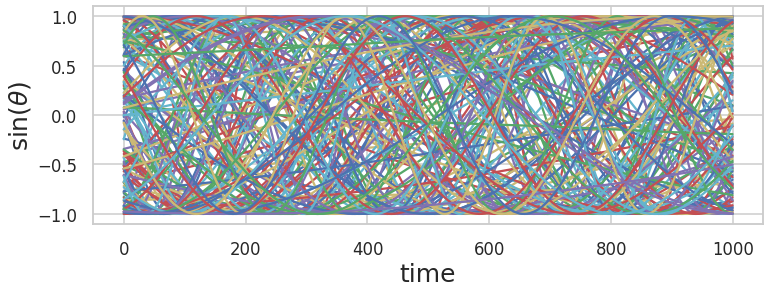

In [8]:
# Instantiate model with parameters
model = Kuramoto(coupling=0.1, dt=0.01, T=10, n_nodes=len(graph), natfreqs=np.random.normal(0,1,len(graph)))

# Run simulation - output is time series for all nodes (node vs time)
act_mat = model.run(adj_mat=graph)

# Plot all the time series
plt.figure(figsize=(12, 4))
plt.plot(np.sin(act_mat.T))
plt.xlabel('time', fontsize=25)
plt.ylabel(r'$\sin(\theta)$', fontsize=25)

In [35]:
act_mat.T

array([[  2.27535285,   5.87897055,   5.35576876, ...,   4.55626268,
          2.12624447,   4.28793069],
       [  2.26339661,   5.84895036,   5.3578903 , ...,   4.56104757,
          2.11961596,   4.28524559],
       [  2.25137297,   5.81902236,   5.36005011, ...,   4.56588133,
          2.11292746,   4.28260822],
       ...,
       [ -9.5850005 , -22.05483078,   9.14961594, ...,   9.63585973,
         -4.13696727,  -0.33448854],
       [ -9.5959166 , -22.08373632,   9.15158451, ...,   9.63907628,
         -4.1449259 ,  -0.33994799],
       [ -9.60688536, -22.1127401 ,   9.15353447, ...,   9.64228138,
         -4.15292694,  -0.34537172]])

In [29]:
[model.phase_coherence(vec)
     for vec in act_mat.T]

[0.34817305353211014,
 0.35119833308045234,
 0.3542253036212356,
 0.3572524677520747,
 0.3602783526419508,
 0.3633015013711338,
 0.366320473631005,
 0.3693338440930937,
 0.3723402014472887,
 0.3753381476165386,
 0.3783262949317787,
 0.3813032693144156,
 0.38426770646780684,
 0.3872182521403203,
 0.3901535615889977,
 0.3930722995937791,
 0.3959731399799588,
 0.3988547661133,
 0.40171587063315534,
 0.4045551559511922,
 0.40737133503932454,
 0.4101631315907299,
 0.4129292809419336,
 0.4156685308717075,
 0.41837964233560715,
 0.4210613908388272,
 0.42371256719579803,
 0.4263319786201611,
 0.42891845023388214,
 0.43147082581987684,
 0.43398796923144256,
 0.43646876571543797,
 0.43891212276149316,
 0.44131697167980594,
 0.4436822684857604,
 0.4460069947953846,
 0.4482901592250929,
 0.4505307987005045,
 0.45272797867713127,
 0.4548807942788526,
 0.45698837162262596,
 0.4590498680057645,
 0.4610644726126824,
 0.46303140749635685,
 0.4649499280810721,
 0.4668193234759645,
 0.46863891702381266,


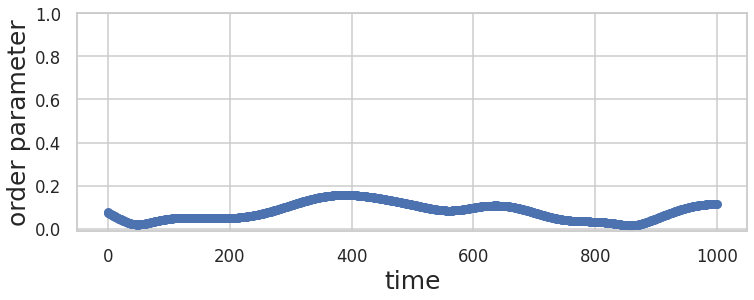

In [9]:
# Plot evolution of global order parameter R_t
plt.figure(figsize=(12, 4))
plt.plot(
    [model.phase_coherence(vec)
     for vec in act_mat.T],
    'o'
)
plt.ylabel('order parameter', fontsize=25)
plt.xlabel('time', fontsize=25)
plt.ylim((-0.01, 1))
plt.show()

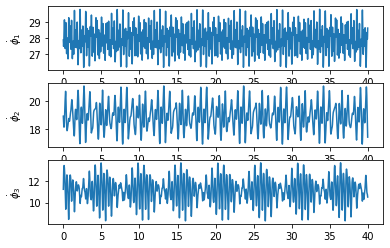

In [5]:
import numpy as np
import pylab as plt
import kuramoto

 
# Defining time array
t0, t1, dt = 0, 40, 0.01
T = np.arange(t0, t1, dt)
 
# Y0, W, K are initial phase, intrinsic freq and
# coupling K matrix respectively
Y0 = np.array([0, np.pi, 0])
W = np.array([28, 19, 11])
 
K1 = np.array([[  0, 0.2,  1.1],
               [0.5,   0, -0.7],
               [0.3, 0.9,    0]])
 
K2 = np.array([[   0, -0.5, 0.2],
               [-0.4,    0, 1.0],
               [ 0.8,  0.8,   0]])
K = np.dstack((K1, K2)).T
 
# Passing parameters as a dictionary
init_params = {'W':W, 'K':K, 'Y0':Y0}
 
# Running Kuramoto model
kuramoto = kuramoto.Kuramoto(init_params)
odePhi = kuramoto.solve(T)
 
# Computing phase dynamics
phaseDynamics = np.diff(odePhi)/dt
 
# Plotting response
nOsc = len(W)
for osc in range(nOsc):
    plt.subplot(nOsc, 1, 1+osc)
    plt.plot(T[:-1], phaseDynamics[osc])
    plt.ylabel("$\dot\phi_{%i}$" %(osc+1))
plt.show()

In [220]:
nx.write_gexf(mst_list[0], "test.gexf")

In [219]:
mst_list

## Period 1: 2019-03-01 to 2019-06-01

Community 0
Community 1
Community 2
Community 3
Community 4


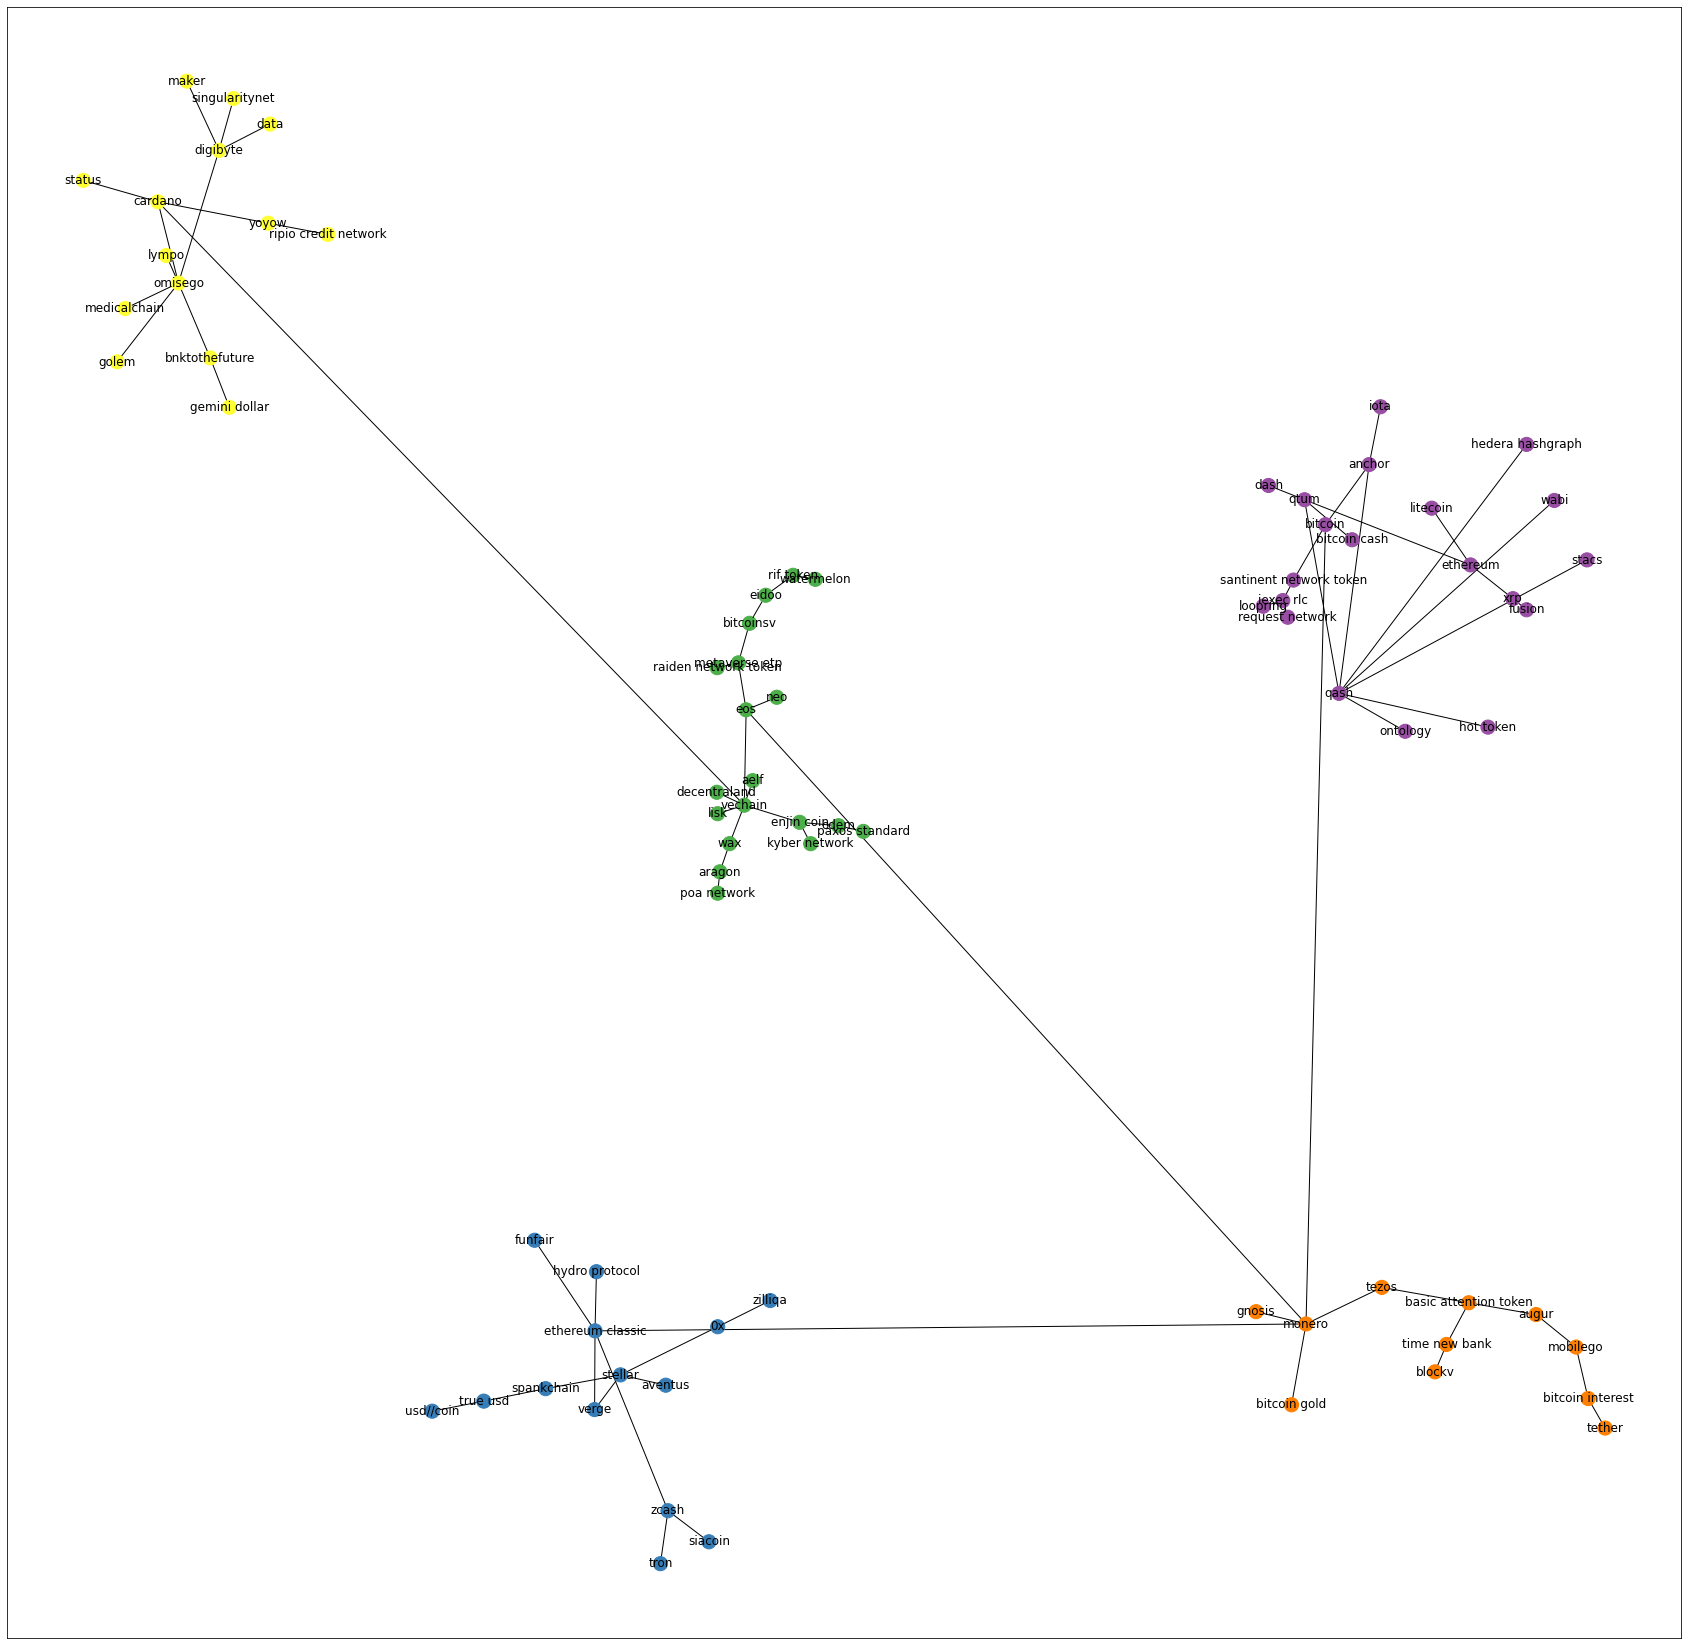

In [224]:
girvan_newman_graph(mst_list[0])

Community 0
Community 1
Community 2
Community 3
Community 4


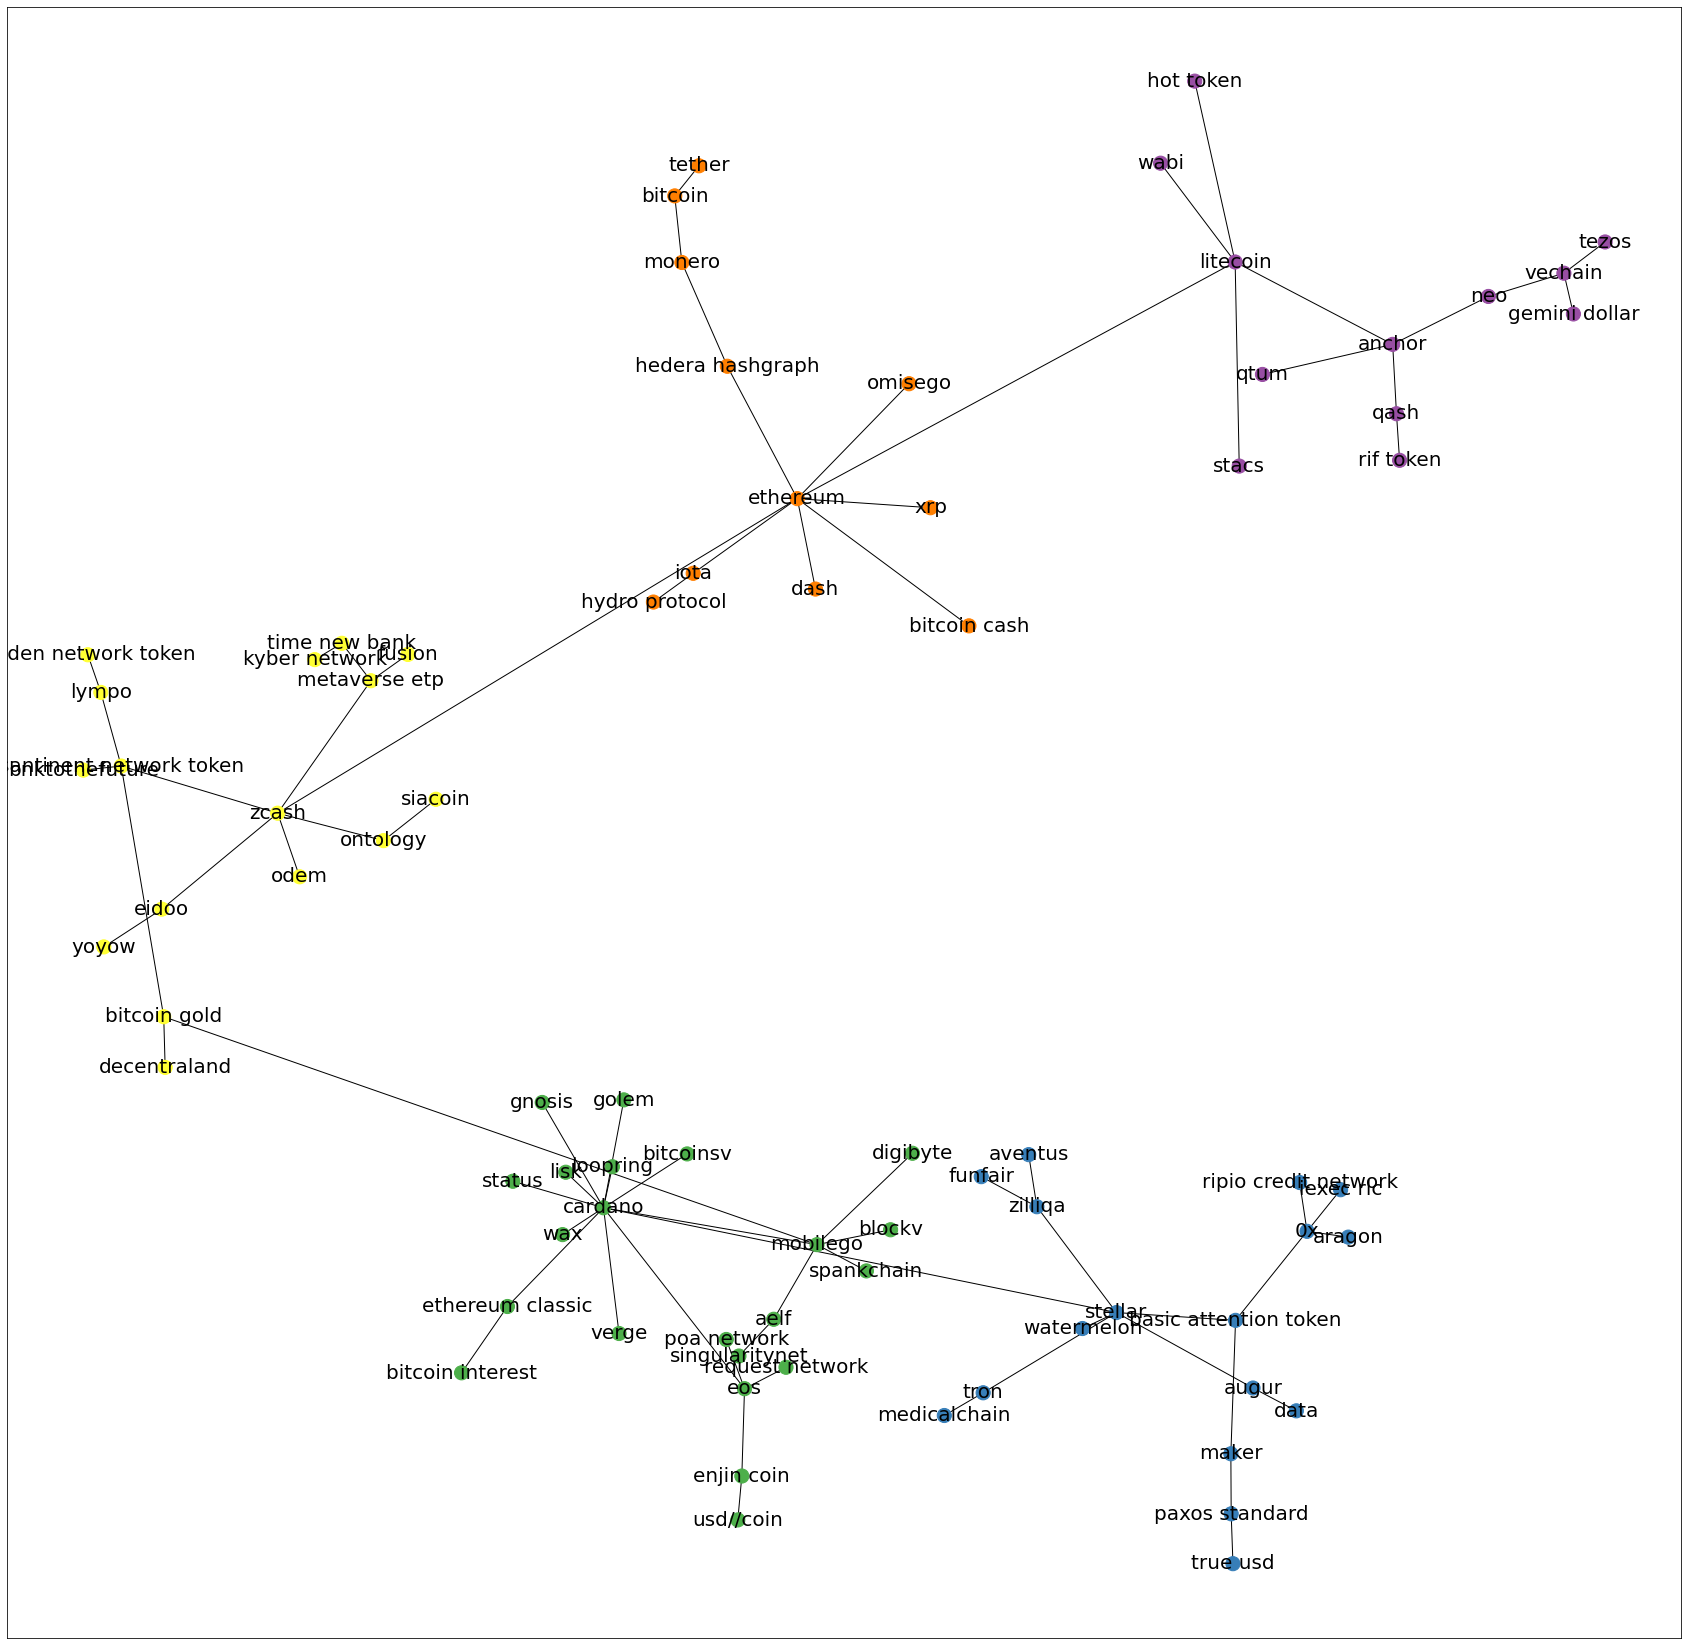

In [199]:
girvan_newman_graph(mst_list[1])

Community 0
Community 1
Community 2
Community 3
Community 4


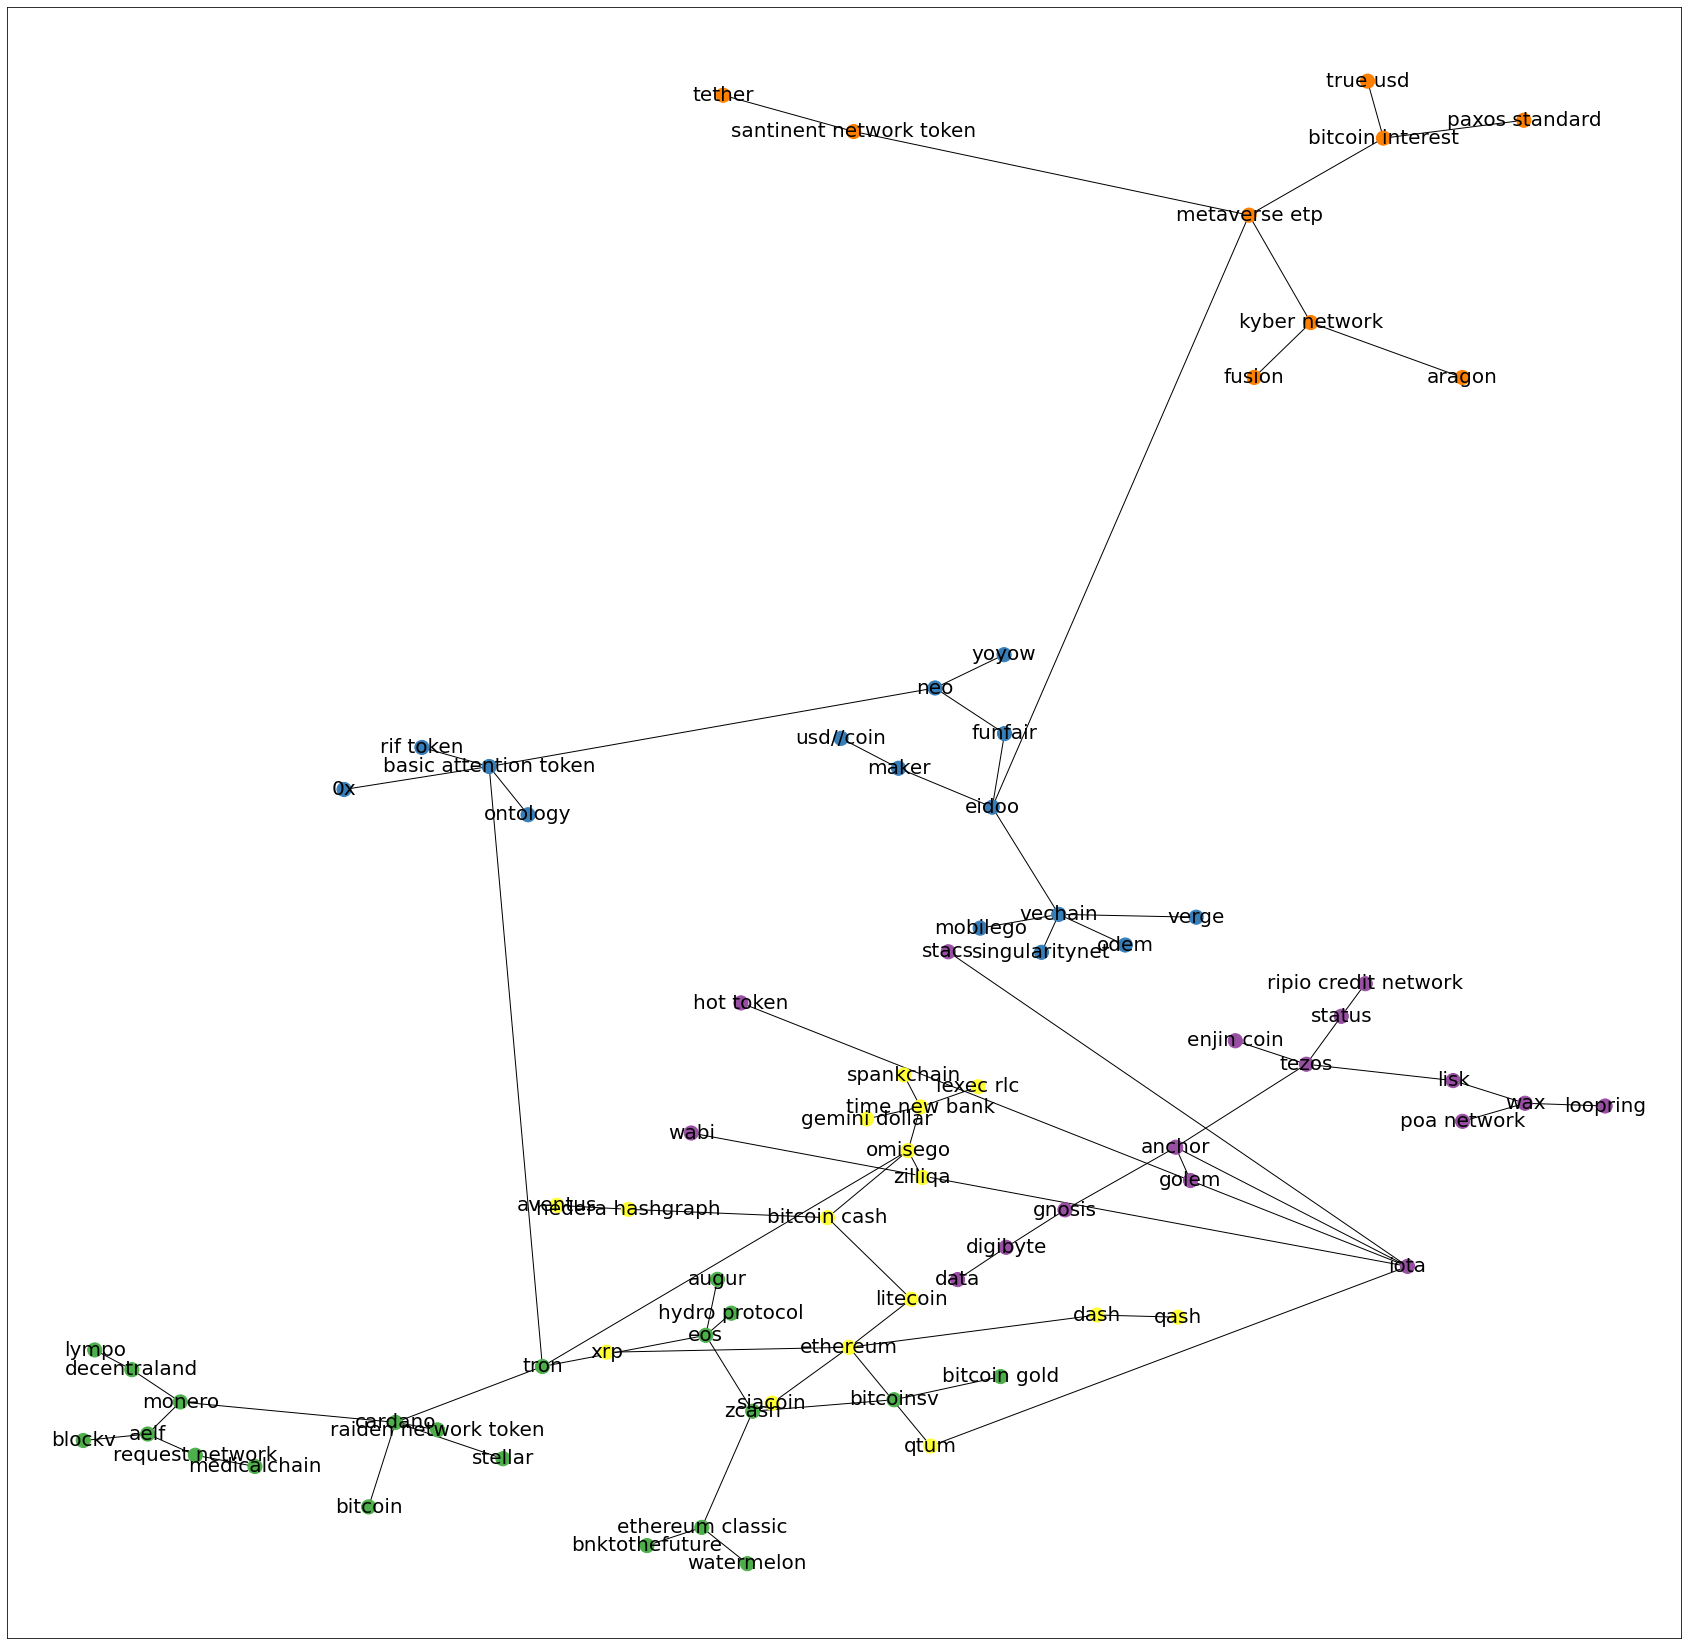

In [218]:
girvan_newman_graph(mst_list[2])

In [63]:
girvan_newman_graph(mst_list[3])

IndexError: list index out of range

Community 0
Community 1
Community 2
Community 3
Community 4


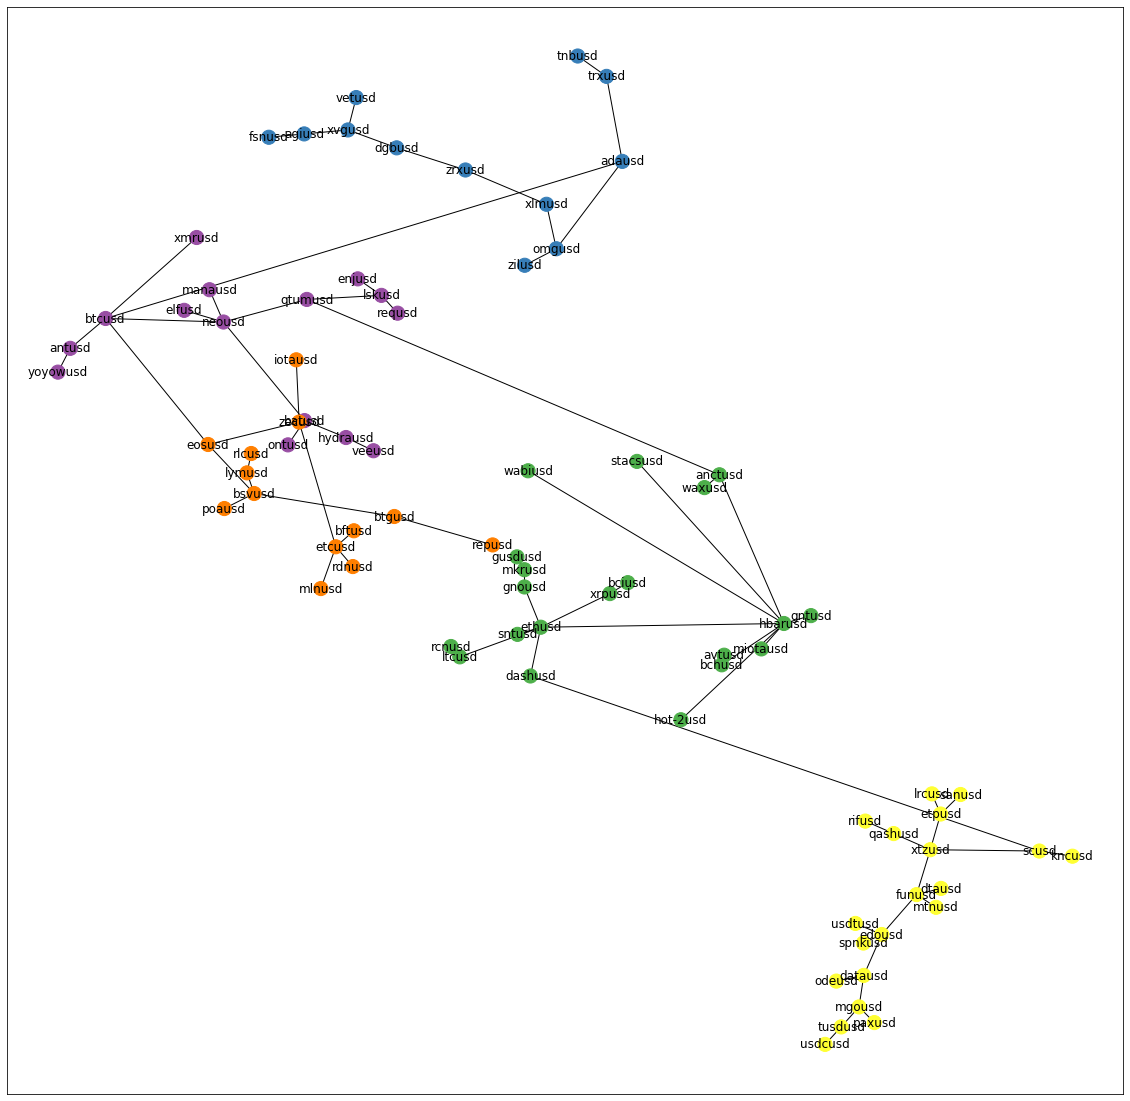

In [57]:
girvan_newman_graph(mst_list[4])